# Combining Marine Vessel Traffic and Sea Ice Concentration Data

In this notebook, we demonstrate a method for combining the [North Pacific and Arctic Marine Vessel Traffic Dataset](https://www.sciencedirect.com/science/article/pii/S2352340922007387) with [Historical Sea Ice Concentration](https://snap.uaf.edu/tools/sea-ice-atlas) data from the SNAP Data API. Vessel traffic data has been pre-aggregated into hexagons, and we use the centroids of those hexagons to query SNAP Data API for sea ice concentration. We then summarize and plot vessel traffic over time by aggregating the combined dataset into latitude groups.

Vessel traffic data should be downloaded from [here](https://search.dataone.org/view/doi%3A10.18739%2FA2XG9FC41) and unzipped locally before running the notebook. A shapefile of the continents is also used for context in plotting; optionally, that data can be downloaded [here](https://pubs.usgs.gov/of/2006/1187/basemaps/continents/continents.zip). 

### Setup
Load required packages.

In [1]:
import pandas as pd
import geopandas as gpd
import aiohttp
import asyncio
import os
import matplotlib.pyplot as plt
from pyproj import Transformer
import numpy as np

### Read in vessel traffic data

Given the directory with all unzipped vessel traffic hexagon shapefiles, list them and iterate through the list to read them into geodataframes. Concatenate all of them into one geodataframe. According to the metadata, these hexagons and their coordinates are in the Alaska Albers projection (EPSG:3338). But in order to query the API, we need point locations in WGS84 (EPSG:4326). So we will extract the centroid of each hexagon, convert the coordinates to EPSG:4326, and add those as new geometric attributes. We also add an empty attribute to hold sea ice concentration values that we fetch via the SNAP Data API.

In [2]:
data_dir = "/home/UA/jdpaul3/testing/ARDAC_nbs/data/data"

paths = []
for root, dir, files in os.walk(data_dir):
    for f in files:
        if f.endswith(".shp"):
            paths.append(os.path.join(root,f))

crs = gpd.read_file(paths[0]).crs
gdf_3338 = gpd.GeoDataFrame(pd.concat([gpd.read_file(i).to_crs(crs) for i in paths], ignore_index=True), crs=crs)

gdf_3338['centroid'] = gdf_3338.geometry.centroid
gdf_4326 = gdf_3338.set_geometry(col='centroid').to_crs(4326)
gdf_3338["LON_4326"] = gdf_4326.geometry.x
gdf_3338["LAT_4326"] = gdf_4326.geometry.y
#optionally, save the concatenated output for future use
#gdf_3338.to_file("/home/UA/jdpaul3/testing/ARDAC_nbs/data/shipping_hex_concat.shp")
gdf_3338["sea_ice_concentration"] = None

gdf_3338.head()

,hexID,year,month,SOG_C,SOGsd_C,nMMSI_C,nOprD_C,SOG_T,SOGsd_T,nMMSI_T,...,nOPrD_L,SOG_A,SOGsd_A,nMMSI_A,nOprD_A,geometry,centroid,LON_4326,LAT_4326,sea_ice_concentration
0,1,2020,08,20.325000,0.046291,1.0,1.0,NaN,NaN,NaN,...,1.0,20.325000,0.046291,1.0,1.0,"POLYGON ((-1541845.047 226864.240, -1534090.00...",POINT (-1526334.971 226864.240),-175.375793,49.810191,None
1,2,2020,08,13.136860,1.395568,9.0,9.0,NaN,NaN,NaN,...,10.0,13.084026,1.368019,10.0,10.0,"POLYGON ((-1495314.819 226864.240, -1487559.78...",POINT (-1479804.743 226864.240),-174.766395,49.941912,None
2,3,2020,08,13.985930,0.701876,7.0,7.0,NaN,NaN,NaN,...,8.0,13.365106,1.604872,8.0,8.0,"POLYGON ((-1448784.590 226864.240, -1441029.55...",POINT (-1433274.514 226864.240),-174.153359,50.069897,None
3,4,2020,08,14.961905,1.757691,5.0,5.0,NaN,NaN,NaN,...,5.0,14.961905,1.757691,5.0,5.0,"POLYGON ((-1565110.162 240296.360, -1557355.12...",POINT (-1549600.085 240296.360),-175.738457,49.858383,None
4,5,2020,08,13.304803,1.725948,18.0,18.0,NaN,NaN,NaN,...,18.0,13.304803,1.725948,18.0,18.0,"POLYGON ((-1518579.933 240296.360, -1510824.89...",POINT (-1503069.857 240296.360),-175.129475,49.992279,None


### Plot hexagons and lines of latitude for context

Next, we will plot some data for spatial context. Read in the continents shapefile, create a standalone hexagon geodataframe, and plot them together. For the lines of latitude, we need to transform the geographic coordinates into EPSG:3338, so we build a transformer and list of latitudes to iterate over. We actually need to create two lines of latitude in order to deal with the dateline at longitude -180/180. We use `np.linspace()` to fill in two lists of longitude coordinates (160 to 180, and -180 to -135) which we then plot with identical styles. These two lines meet on the map and appear as one. Finally, we add some annotation.

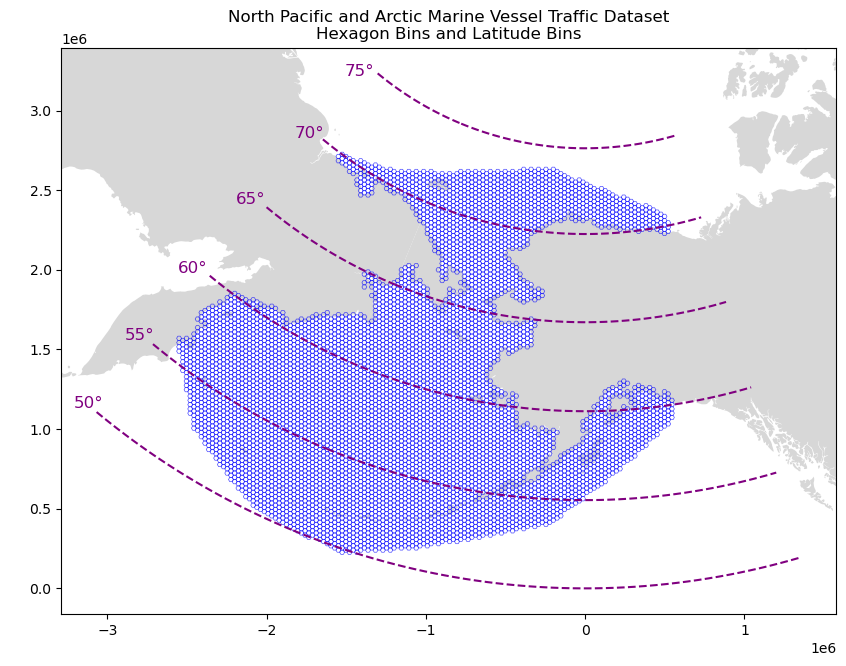

In [3]:
continents_3338 = gpd.read_file("/home/UA/jdpaul3/testing/ARDAC_nbs/data/continent.shp").to_crs(3338)

hex_geom_3338 = gdf_3338.groupby('hexID', as_index=False)['geometry'].first()

fig, ax = plt.subplots(figsize=(10,10))
hex_geom_3338.boundary.plot(figsize=(10,10), ax=ax, linewidth=.5, alpha=.7, color='blue')
continents_3338.plot(ax=ax, linewidth=.7, alpha=.9, color='lightgray')

transformer = Transformer.from_crs("EPSG:4326", "EPSG:3338", always_xy=True)
lats = [50,55,60,65,70,75]

for lat in lats:
    lon1 = np.linspace(160,180)
    lon2 = np.linspace(-180,-135)
    lat_ = np.linspace(lat,lat)
    x1, y1 = transformer.transform(xx=lon1, yy=lat_)
    x2, y2 = transformer.transform(xx=lon2, yy=lat_)
    ax.plot(x1,y1, linewidth=1.5, color='purple',linestyle='--')
    ax.plot(x2,y2, linewidth=1.5, color='purple',linestyle='--')

ax.annotate('50\N{DEGREE SIGN}', xy=(53, 186), xycoords='figure points', fontsize=12, color='purple')
ax.annotate('55\N{DEGREE SIGN}', xy=(90, 235), xycoords='figure points', fontsize=12, color='purple')
ax.annotate('60\N{DEGREE SIGN}', xy=(128, 283), xycoords='figure points', fontsize=12, color='purple')
ax.annotate('65\N{DEGREE SIGN}', xy=(170, 333), xycoords='figure points', fontsize=12, color='purple')
ax.annotate('70\N{DEGREE SIGN}', xy=(212, 380), xycoords='figure points', fontsize=12, color='purple')
ax.annotate('75\N{DEGREE SIGN}', xy=(248, 425), xycoords='figure points', fontsize=12, color='purple')

ax.set_xlim(-3289000, 1577000)
ax.set_ylim(-161600, 3395000)

ax.set_title("North Pacific and Arctic Marine Vessel Traffic Dataset\nHexagon Bins and Latitude Bins")
plt.show()



Using the plot above, we can better visualize how our analysis will work. For each of the hexagons, we now have vessel traffic data for each month from 2015-2020. With the centroid of each hexagon, we will query sea ice concentration for that year and month and add it to the dataset. Within each latitude bin (50-55, 55-60, 60-65, 65-70, 70-75) we will then sum the vessel operating days, average the sea ice concentration, and plot the relationship. 

While this analysis is rather basic and exploratory, it opens the door for more possibilities in working with this dataset and demonstrates some methods you can use to aggregate the datasets.  

### Fetching sea ice data from SNAP Data API

There are multiple years in the vessel traffic dataset, and each one uses the same hexagon grid. Due to the JSON structure of the [sea ice endpoint](https://earthmaps.io/seaice/), we actually only need to request sea ice data once for each hexagon centroid and the SNAP Data API will return all the years and months we need.

Grouping by unique hexagon ID, we use each corresponding 4326 coordinate pair to create a dictionary with hexagon IDs as keys and the SNAP Data API request URL as the values. Then we split the resulting dictionary into three parts, to avoid overloading the server with >5000 requests at once!

In [4]:
hexid_coords = gdf_3338.groupby('hexID')[['LON_4326','LAT_4326']].first()

hexid_url_dict = {}  
for hexid, row in hexid_coords.iterrows():
    lon_str = str(row.LON_4326)
    lat_str = str(row.LAT_4326)
    request_url = str("https://earthmaps.io/seaice/point/" + lat_str + "/" + lon_str)
    hexid_url_dict[hexid] = request_url

dict1 = {k:v for (k,v) in [x for x in hexid_url_dict.items()][:2000]}
dict2 = {k:v for (k,v) in [x for x in hexid_url_dict.items()][2000:4000]}
dict3 = {k:v for (k,v) in [x for x in hexid_url_dict.items()][4000:6000]}
dict4 = {k:v for (k,v) in [x for x in hexid_url_dict.items()][6000:]}

Next we set up `async` request functions: this set of functions opens an HTTP session and makes multiple simultaneous requests to the server. The `main()` function updates an input dictionary with items containing hexagon IDs as keys and JSON responses as values.

In [5]:
async def fetch(session, hexid, url):
    async with session.get(url) as response:
        if response.status != 200:
            print("BAD REQUEST : HEXID " + str(hexid) + ", URL: " + url)
            print("HEXID " + str(hexid) + " will have no results...")
            none_dict =  {hexid: None}
            return none_dict
        else:
            hexid_json_dict = {hexid: await response.json()}
            return hexid_json_dict

async def fetch_all(session, hexid_url_dict):
    tasks = []
    for key in hexid_url_dict:
        task = asyncio.create_task(fetch(session, key, hexid_url_dict[key]))
        tasks.append(task)
    results = await asyncio.gather(*tasks)
    return results

async def main(dict_, result_dict):
    timeout = aiohttp.ClientTimeout(total=900)
    async with aiohttp.ClientSession(timeout=timeout) as session:
        hexid_json_dicts = await fetch_all(session, dict_)
        for d in hexid_json_dicts:
            result_dict.update(d)

Run the function for each hexagon ID/URL dictionary, populating the results dictionary with hexagon ID/JSON sea ice data combinations.

In [6]:
result = {}
for dict_ in [dict1, dict2, dict3, dict4]:
    await main(dict_, result)

Now we can populate the sea ice concentration attribute of the original vessel traffic geodataframe using its year, month, and hexagon ID attributes. For each hexagon, we call the proper result dictionary using a concatenated year-month string. This code snippet also provides an error message if the hexagon ID is not present in the results dictionary, to alert the user that the requested year-month combination is not available in the sea ice dataset.

In [7]:
for index, row in gdf_3338.iterrows():
    hexid = row.hexID
    ym_key = str(row.year) + "-" + str(row.month)
    try:
        sea_ice_concentration = result[hexid][ym_key]
        gdf_3338.loc[index, "sea_ice_concentration"] = sea_ice_concentration
    except:
        print("bad hex/key combo: " + str(hexid) + " : " + ym_key)

Now we can work with the combined vessel/sea ice data! For reference the `nOprD` attribute is number of operating days with each hexagon. There are six different subsets of vessel data: all vessels (denoted with suffix “_A”), vessels categorized by ship type (cargo [\_C], tanker [\_T], fishing [\_F], other [\_O]). For this analysis, we will only use the data for all vessels.

Start by filling NA values with 0s to avoid unintended statistics errors. (In this case, we want to specify that an observation of no vessels is actually a numerical 0, and not an NA value that might be skipped by the function.)

Then we will divide the dataset into bins based on their latitudes. The spatial work has already been done above, so we can just use the `LAT_4326` attribute for binning. 

We want to apply two different functions to attributes the latitude bins; sum for vessel operating days, and mean for sea ice concentration. We use a dictionary to define these functions explicitly for each of the attributes in the dataset, and use that dictionary in the `groupby` operation. (Though we are only going to plot the "all vessels" group, we will also sum the other vessel categories here.) 

Lastly, we invert the sea ice concentration attribute to get a corresponding `open_water_pct` attribute, and create a new column to hold a datetime object for easier plotting.

In [8]:
gdf_3338.fillna(0, inplace=True)

bins = [50,55,60,65,70,75]
group_names=['50-55','55-60','60-65','65-70','70-75']
gdf_3338['lat_bins']=pd.cut(gdf_3338['LAT_4326'], bins, labels=group_names)

f = {'nOprD_A':'sum', 'nOprD_C':'sum', 'nOprD_T':'sum', 'nOprD_F':'sum', 'nOprD_O':'sum', 'sea_ice_concentration':'mean'}
df = gdf_3338.groupby(['year', 'month', 'lat_bins'], observed=True, as_index=False).agg(f)
df["open_water_pct"] = 100 - df["sea_ice_concentration"]
df['day']=1
df["date"] = pd.to_datetime(df[['year', 'month', 'day']])
df

,year,month,lat_bins,nOprD_A,nOprD_C,nOprD_T,nOprD_F,nOprD_O,sea_ice_concentration,open_water_pct,day,date
0,2015,01,50-55,56161.0,44753.0,990.0,6397.0,4021.0,0.0,100.0,1,2015-01-01
1,2015,01,55-60,20717.0,4223.0,680.0,9343.0,6471.0,1.763432,98.236568,1,2015-01-01
2,2015,01,60-65,3882.0,455.0,459.0,541.0,2427.0,27.875676,72.124324,1,2015-01-01
3,2015,01,65-70,0.0,0.0,0.0,0.0,0.0,78.04932,21.95068,1,2015-01-01
4,2015,01,70-75,1.0,0.0,0.0,1.0,0.0,94.514443,5.485557,1,2015-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...
355,2020,12,50-55,49642.0,44428.0,1820.0,2121.0,1273.0,0.161747,99.838253,1,2020-12-01
356,2020,12,55-60,17607.0,5169.0,1372.0,8295.0,2771.0,1.201684,98.798316,1,2020-12-01
357,2020,12,60-65,9801.0,1231.0,673.0,5466.0,2431.0,9.377477,90.622523,1,2020-12-01
358,2020,12,65-70,276.0,44.0,80.0,37.0,115.0,42.032313,57.967687,1,2020-12-01


### Plotting open water & vessel operating days by latitude

Now that we have all of our data combined and aggregated, we can plot all vessel operating days against open water percentage for latitude bin. We will use a separate plot for each latitude bin, and plot the entire time series for each bin.

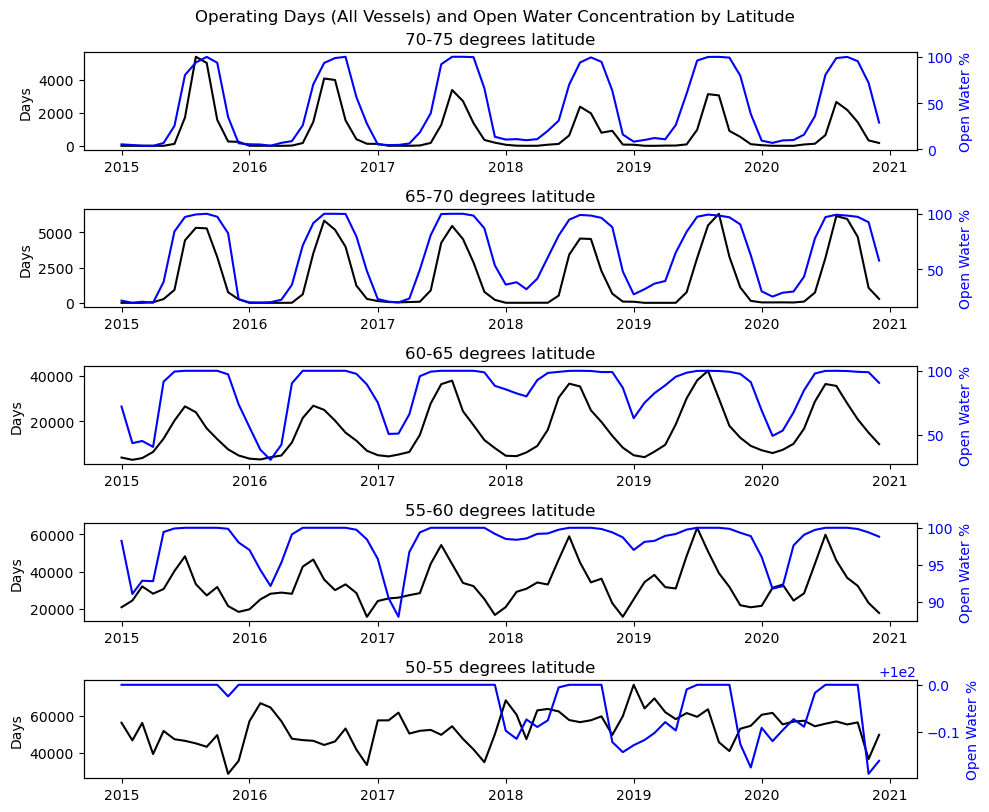

In [11]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10,8))

axes = [ax1, ax2, ax3, ax4, ax5]
ax1a, ax2a, ax3a, ax4a, ax5a = ax1.twinx(), ax2.twinx(), ax3.twinx(), ax4.twinx(), ax5.twinx()
twin_axes = [ax1a, ax2a, ax3a, ax4a, ax5a]

group_names.reverse() #we will plot with the northern-most latitude at the top of the figure

for l, ax, twin in zip(group_names, axes, twin_axes):
    
    x = df[df.lat_bins==l].date
    y1 = df[df.lat_bins==l].open_water_pct
    y2 = df[df.lat_bins==l].nOprD_A

    ax.set_ylabel('Days', color='black')
    ax.tick_params(axis='y', labelcolor='black')
    ax.plot(x, y2, color='black')

    twin.set_ylabel('Open Water %', color='blue')
    twin.tick_params(axis='y', labelcolor='blue')
    twin.plot(x, y1, color='blue')

    ax.set_title(str(l + " degrees latitude"))
    
fig.tight_layout()
fig.suptitle("Operating Days (All Vessels) and Open Water Concentration by Latitude", y=1.01)
plt.show()



### Mapping summer months mean sea ice concentration

Group the data by hexagon ID and month, and make three plots of mean 2015-2020 sea ice concentration for June, July, and August. As in the map above, add the latitude lines for context.

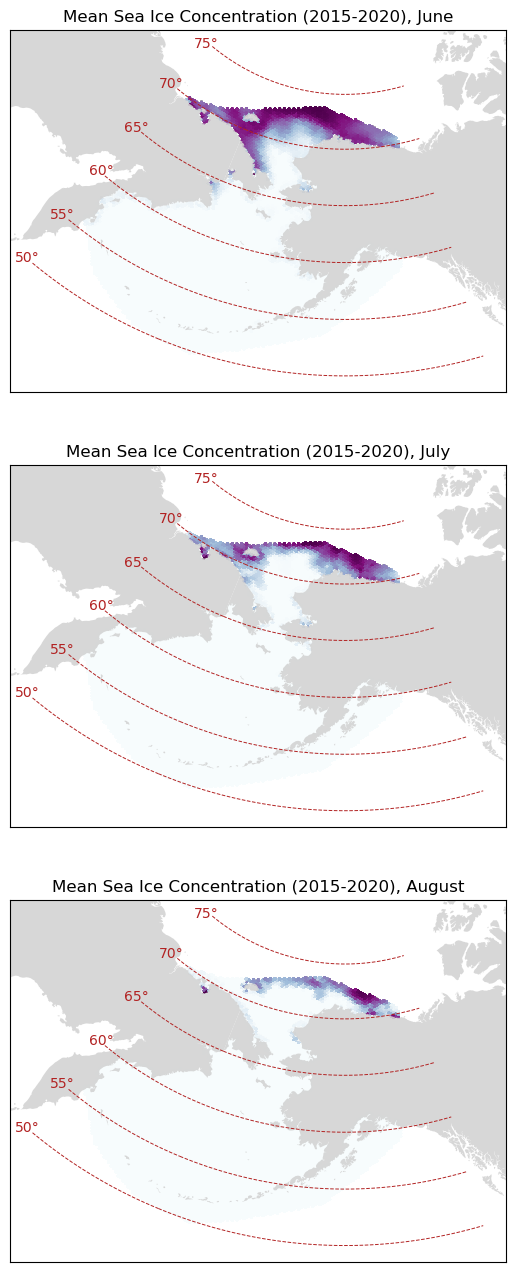

In [46]:
map_df = gdf_3338[gdf_3338['month'].isin(['06', '07', '08'])].groupby(['hexID', 'month'], observed=True, as_index=False)['sea_ice_concentration'].mean()
map_df = map_df.merge(gdf_3338[['hexID', 'geometry']], on='hexID')
map_gdf = gpd.GeoDataFrame(map_df, geometry='geometry', crs=3338)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,16))

for m, ax, m_name in zip(['06', '07', '08'], [ax1, ax2, ax3], ['June', 'July', 'August']):
    df = map_gdf[map_gdf['month']==m]
    df.plot('sea_ice_concentration', cmap='BuPu', ax=ax, alpha=.5)

    continents_3338.plot(ax=ax, linewidth=.7, alpha=.9, color='lightgray')

    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3338", always_xy=True)
    lats = [50,55,60,65,70,75]

    for lat in lats:
        lon1 = np.linspace(160,180)
        lon2 = np.linspace(-180,-135)
        lat_ = np.linspace(lat,lat)
        x1, y1 = transformer.transform(xx=lon1, yy=lat_)
        x2, y2 = transformer.transform(xx=lon2, yy=lat_)
        ax.plot(x1,y1, linewidth=.7, color='firebrick',linestyle='--')
        ax.plot(x2,y2, linewidth=.7, color='firebrick',linestyle='--')

    ax.annotate('50\N{DEGREE SIGN}', xy=(.01, .36), xycoords='axes fraction', fontsize=10, color='firebrick')
    ax.annotate('55\N{DEGREE SIGN}', xy=(.08, .48), xycoords='axes fraction', fontsize=10, color='firebrick')
    ax.annotate('60\N{DEGREE SIGN}', xy=(.16, .60), xycoords='axes fraction', fontsize=10, color='firebrick')
    ax.annotate('65\N{DEGREE SIGN}', xy=(.23, .72), xycoords='axes fraction', fontsize=10, color='firebrick')
    ax.annotate('70\N{DEGREE SIGN}', xy=(.30, .84), xycoords='axes fraction', fontsize=10, color='firebrick')
    ax.annotate('75\N{DEGREE SIGN}', xy=(.37, .95), xycoords='axes fraction', fontsize=10, color='firebrick')

    ax.set_xlim(-3289000, 1577000)
    ax.set_ylim(-161600, 3395000)

    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticklabels([])
    ax.set_yticks([])

    ax.set_title("Mean Sea Ice Concentration (2015-2020), " + m_name)

plt.show()
